In [5]:
from datetime import datetime
import warnings
import os

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
from prophet import Prophet
from prophet.utilities import regressor_coefficients

from get_model_training_data_05 import get_features_and_data
from get_model_training_data_05 import weighted_absolute_percentage_error as wape

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

## Load Training and Testing Data

In [6]:
(df, train_df, test_df, features, next_month) = get_features_and_data()

training examples = 2323, testing examples = 259


In [7]:
test_df = test_df.rename(columns={"index" : "ds", "prob_of_release" : "y"})

## Model-Building and Evaluation

In [8]:
def train_model(this_train_df):
    current_features = ["days_since_previous_release", "previous_release_post", "month_holidays", "M_Sep"]
    df = this_train_df[["index", "prob_of_release"] + current_features].copy()
    df = df.rename(columns={"index" : "ds", "prob_of_release" : "y"})
    df["y"] = np.log(df["y"])

    m = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False, growth="flat",
                mcmc_samples=500, interval_width=0.95, seasonality_prior_scale=15, seasonality_mode="multiplicative")
    m.add_country_holidays("US")
    for col in current_features:
        m.add_regressor(col)

    m.fit(df, seed=1024)
    print(m.stan_fit.diagnose())

    return m

In [9]:
model = train_model(train_df)

17:01:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:01:13 - cmdstanpy - INFO - CmdStan done processing.
17:01:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_359nec7q0r/croot/prophet_1689928107726/work/build/lib.macosx-11.1-arm64-cpython-311/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_359nec7q0r/croot/prophet_1689928107726/work/build/lib.macosx-11.1-arm64-cpython-311/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_359nec7q0r/croot/prophet_1689928107726/work/build/lib.macosx-11.1-arm64-cpython-311/prophet/stan_model/prophet.stan', line


Processing csv files: /var/folders/27/4lgrxy2s2cd_ffjxxt7ww73c0000gn/T/tmpvogzg_f2/prophet_modela_wc8iep/prophet_model-20240319170105_1.csv, /var/folders/27/4lgrxy2s2cd_ffjxxt7ww73c0000gn/T/tmpvogzg_f2/prophet_modela_wc8iep/prophet_model-20240319170105_2.csv, /var/folders/27/4lgrxy2s2cd_ffjxxt7ww73c0000gn/T/tmpvogzg_f2/prophet_modela_wc8iep/prophet_model-20240319170105_3.csv, /var/folders/27/4lgrxy2s2cd_ffjxxt7ww73c0000gn/T/tmpvogzg_f2/prophet_modela_wc8iep/prophet_model-20240319170105_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [10]:
test_hat_df = model.predict(test_df)[["ds", "yhat_lower", "yhat", "yhat_upper"]]
test_hat_df = test_hat_df.merge(test_df[["ds", "y"]], on=["ds"], how="left")

for col in test_hat_df.columns:
    if "yhat" in col:
        test_hat_df[col] = np.exp(test_hat_df[col])
        test_hat_df[col] = test_hat_df[col].apply(lambda x : 0 if x < 0 else (1 if x > 1 else x))

In [11]:
mape(test_hat_df["y"], test_hat_df["yhat"])

0.29283204704866916

In [12]:
wape(test_hat_df["y"], test_hat_df["yhat"])

0.2725274957040354

In [13]:
regressor_coef = regressor_coefficients(model)
regressor_coef.sort_values(by=["coef"], ascending=False)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
1,previous_release_post,multiplicative,0.000000,1.281367,1.382854,1.496524
2,month_holidays,multiplicative,1.445975,-0.044718,-0.021408,0.001127
0,days_since_previous_release,multiplicative,4.903573,-0.160000,-0.150558,-0.141033
3,M_Sep,multiplicative,0.000000,-0.252552,-0.153878,-0.056921


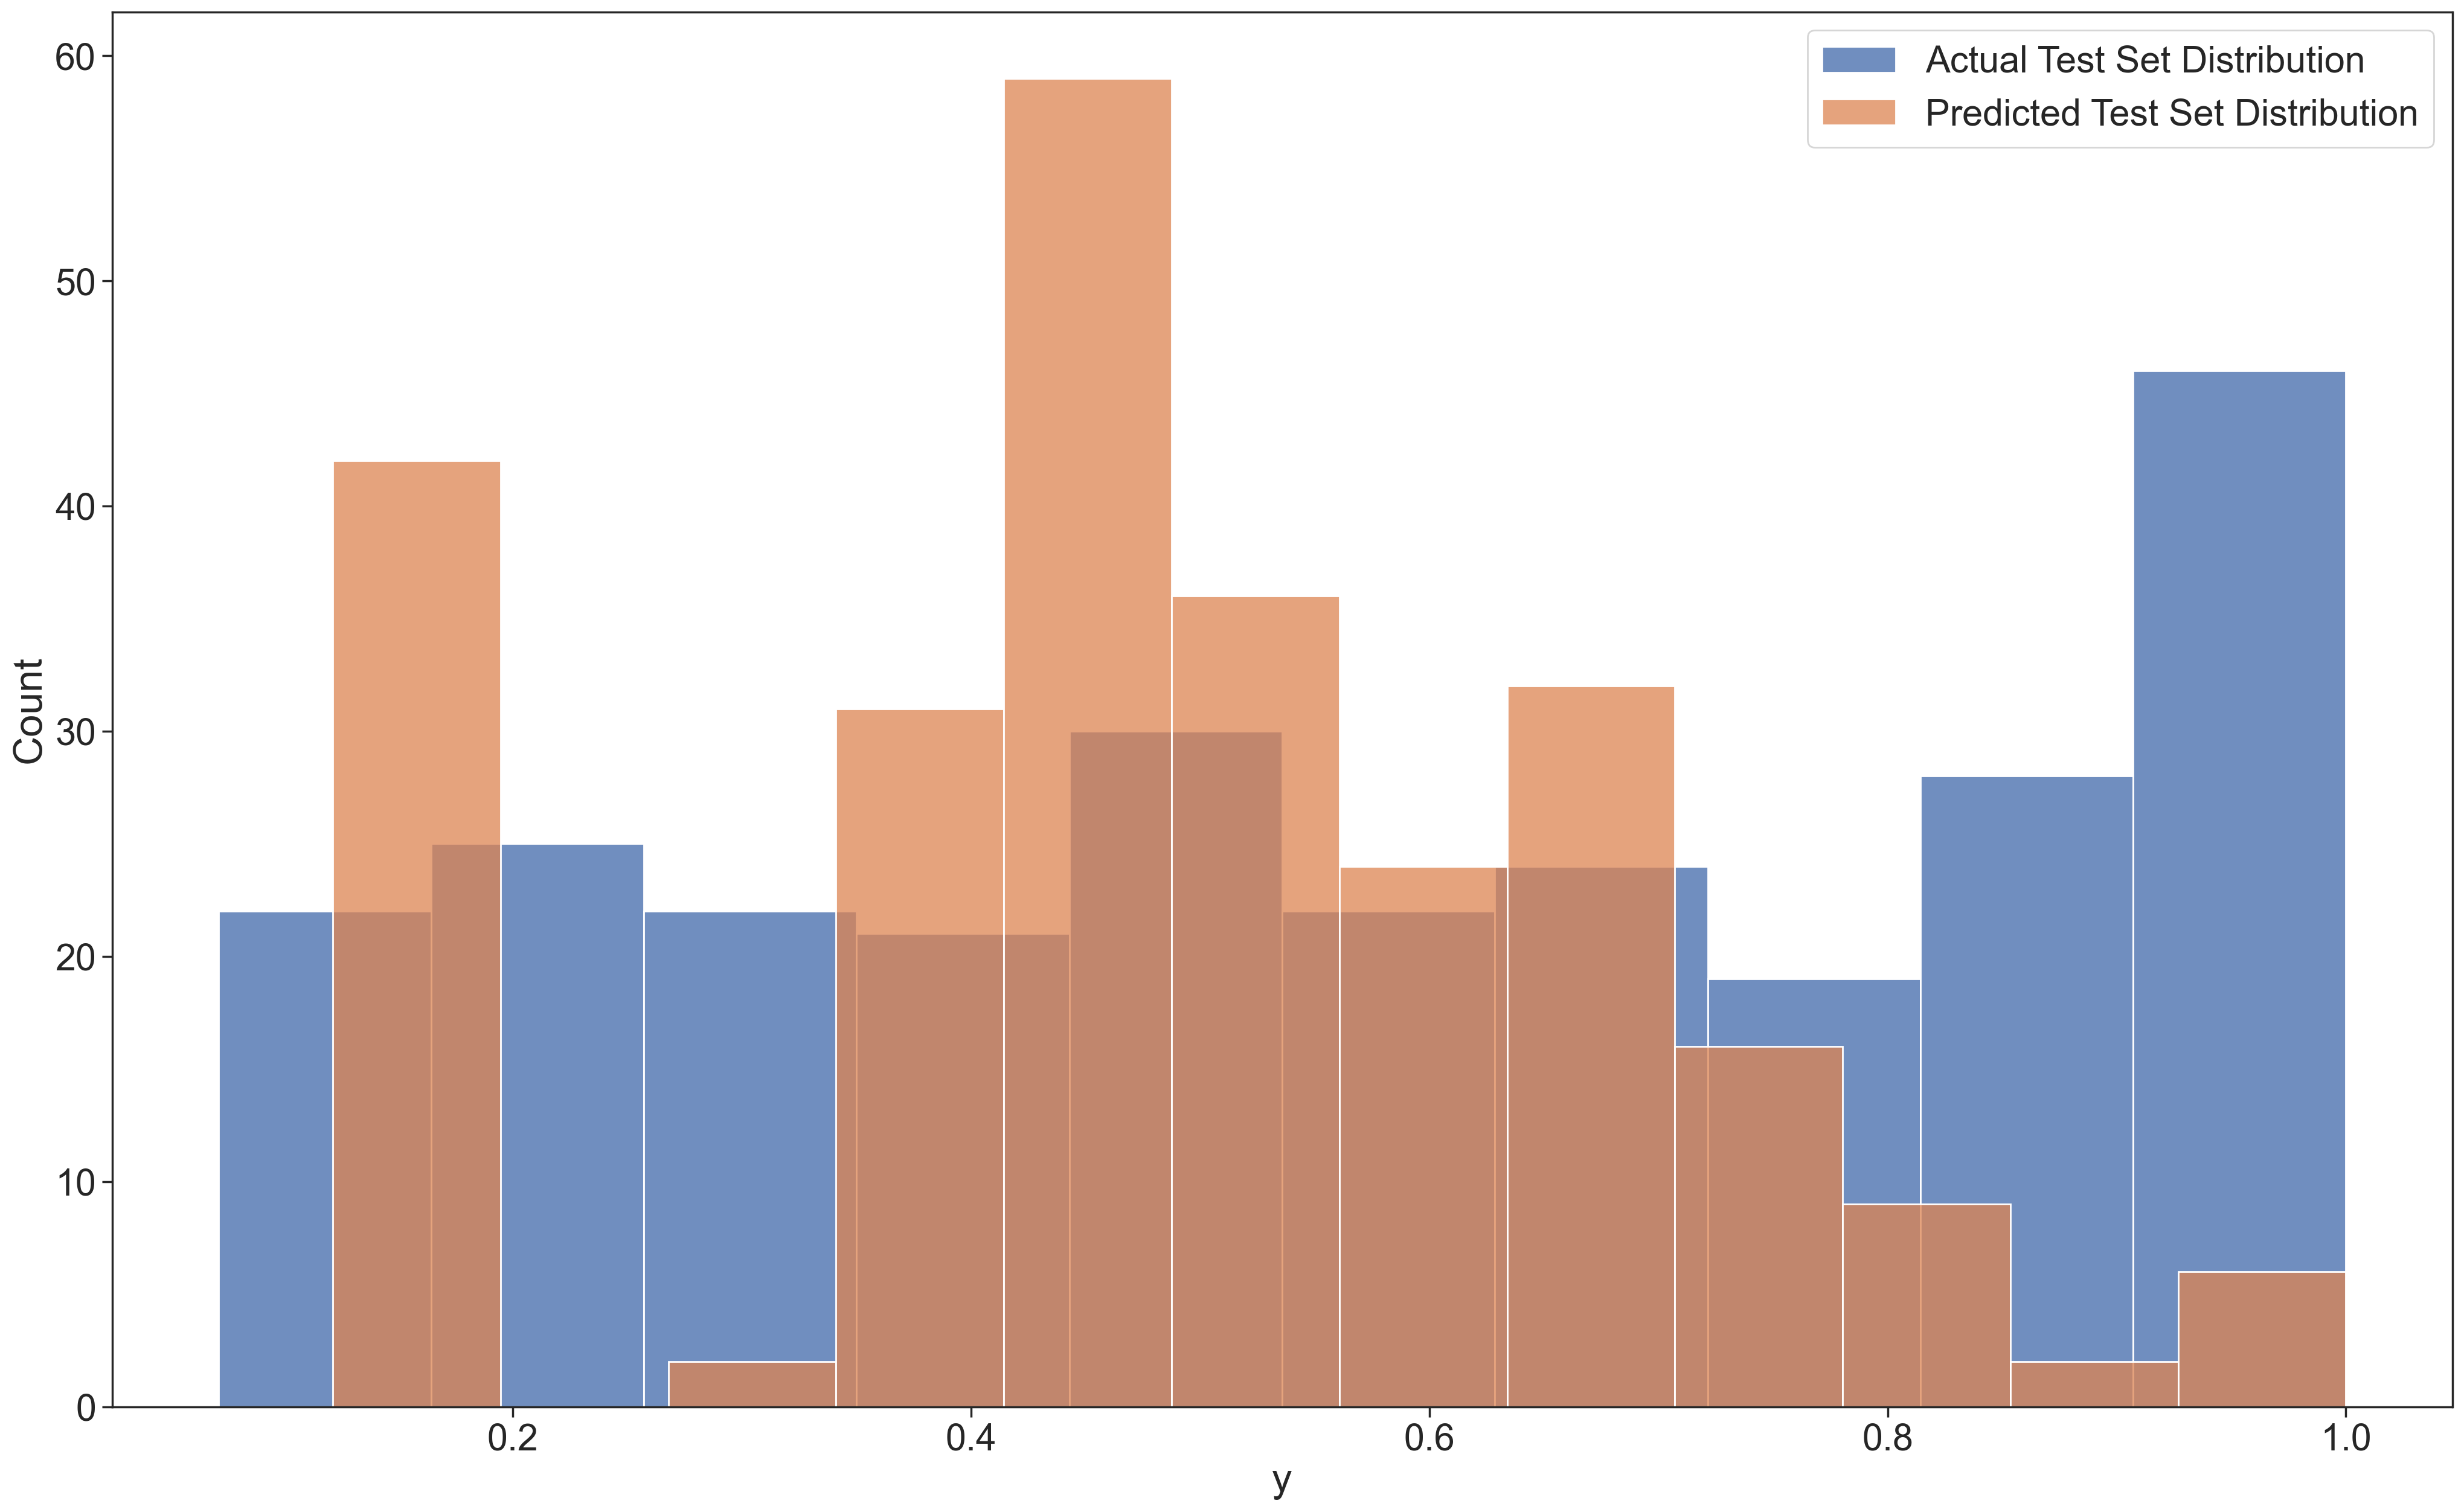

In [14]:
ax = sns.histplot(x=test_hat_df["y"], alpha=0.8, label="Actual Test Set Distribution")
sns.histplot(x=test_hat_df["yhat"], ax=ax, label="Predicted Test Set Distribution")
ax.legend()
plt.show()

## Predictions for the Next Month

In [15]:
model = train_model(df)

17:01:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:01:23 - cmdstanpy - INFO - CmdStan done processing.
17:01:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_359nec7q0r/croot/prophet_1689928107726/work/build/lib.macosx-11.1-arm64-cpython-311/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_359nec7q0r/croot/prophet_1689928107726/work/build/lib.macosx-11.1-arm64-cpython-311/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_359nec7q0r/croot/prophet_1689928107726/work/build/lib.macosx-11.1-arm64-cpython-311/prophet/stan_model/prophet.stan', line


Processing csv files: /var/folders/27/4lgrxy2s2cd_ffjxxt7ww73c0000gn/T/tmpvogzg_f2/prophet_modeldai89f6_/prophet_model-20240319170115_1.csv, /var/folders/27/4lgrxy2s2cd_ffjxxt7ww73c0000gn/T/tmpvogzg_f2/prophet_modeldai89f6_/prophet_model-20240319170115_2.csv, /var/folders/27/4lgrxy2s2cd_ffjxxt7ww73c0000gn/T/tmpvogzg_f2/prophet_modeldai89f6_/prophet_model-20240319170115_3.csv, /var/folders/27/4lgrxy2s2cd_ffjxxt7ww73c0000gn/T/tmpvogzg_f2/prophet_modeldai89f6_/prophet_model-20240319170115_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [16]:
next_month = next_month.rename(columns={"index" : "ds"})

In [17]:
next_month_hat = model.predict(next_month)[["ds", "yhat_lower", "yhat", "yhat_upper"]]
for col in next_month_hat.columns:
    if "yhat" in col:
        next_month_hat[col] = np.exp(next_month_hat[col])
        next_month_hat[col] = next_month_hat[col].apply(lambda x : 0 if x < 0 else (1 if x > 1 else x))

In [18]:
next_month_hat

,ds,yhat_lower,yhat,yhat_upper
0,2024-03-19,0.256344,0.569441,1
1,2024-03-20,0.294193,0.658079,1
2,2024-03-21,0.308061,0.717495,1
3,2024-03-22,0.321425,0.727250,1
4,2024-03-23,0.339204,0.743301,1
5,2024-03-24,0.347640,0.810013,1
6,2024-03-25,0.425718,0.920530,1
7,2024-03-26,0.481480,1.000000,1
8,2024-03-27,0.595088,1.000000,1
9,2024-03-28,0.611607,1.000000,1


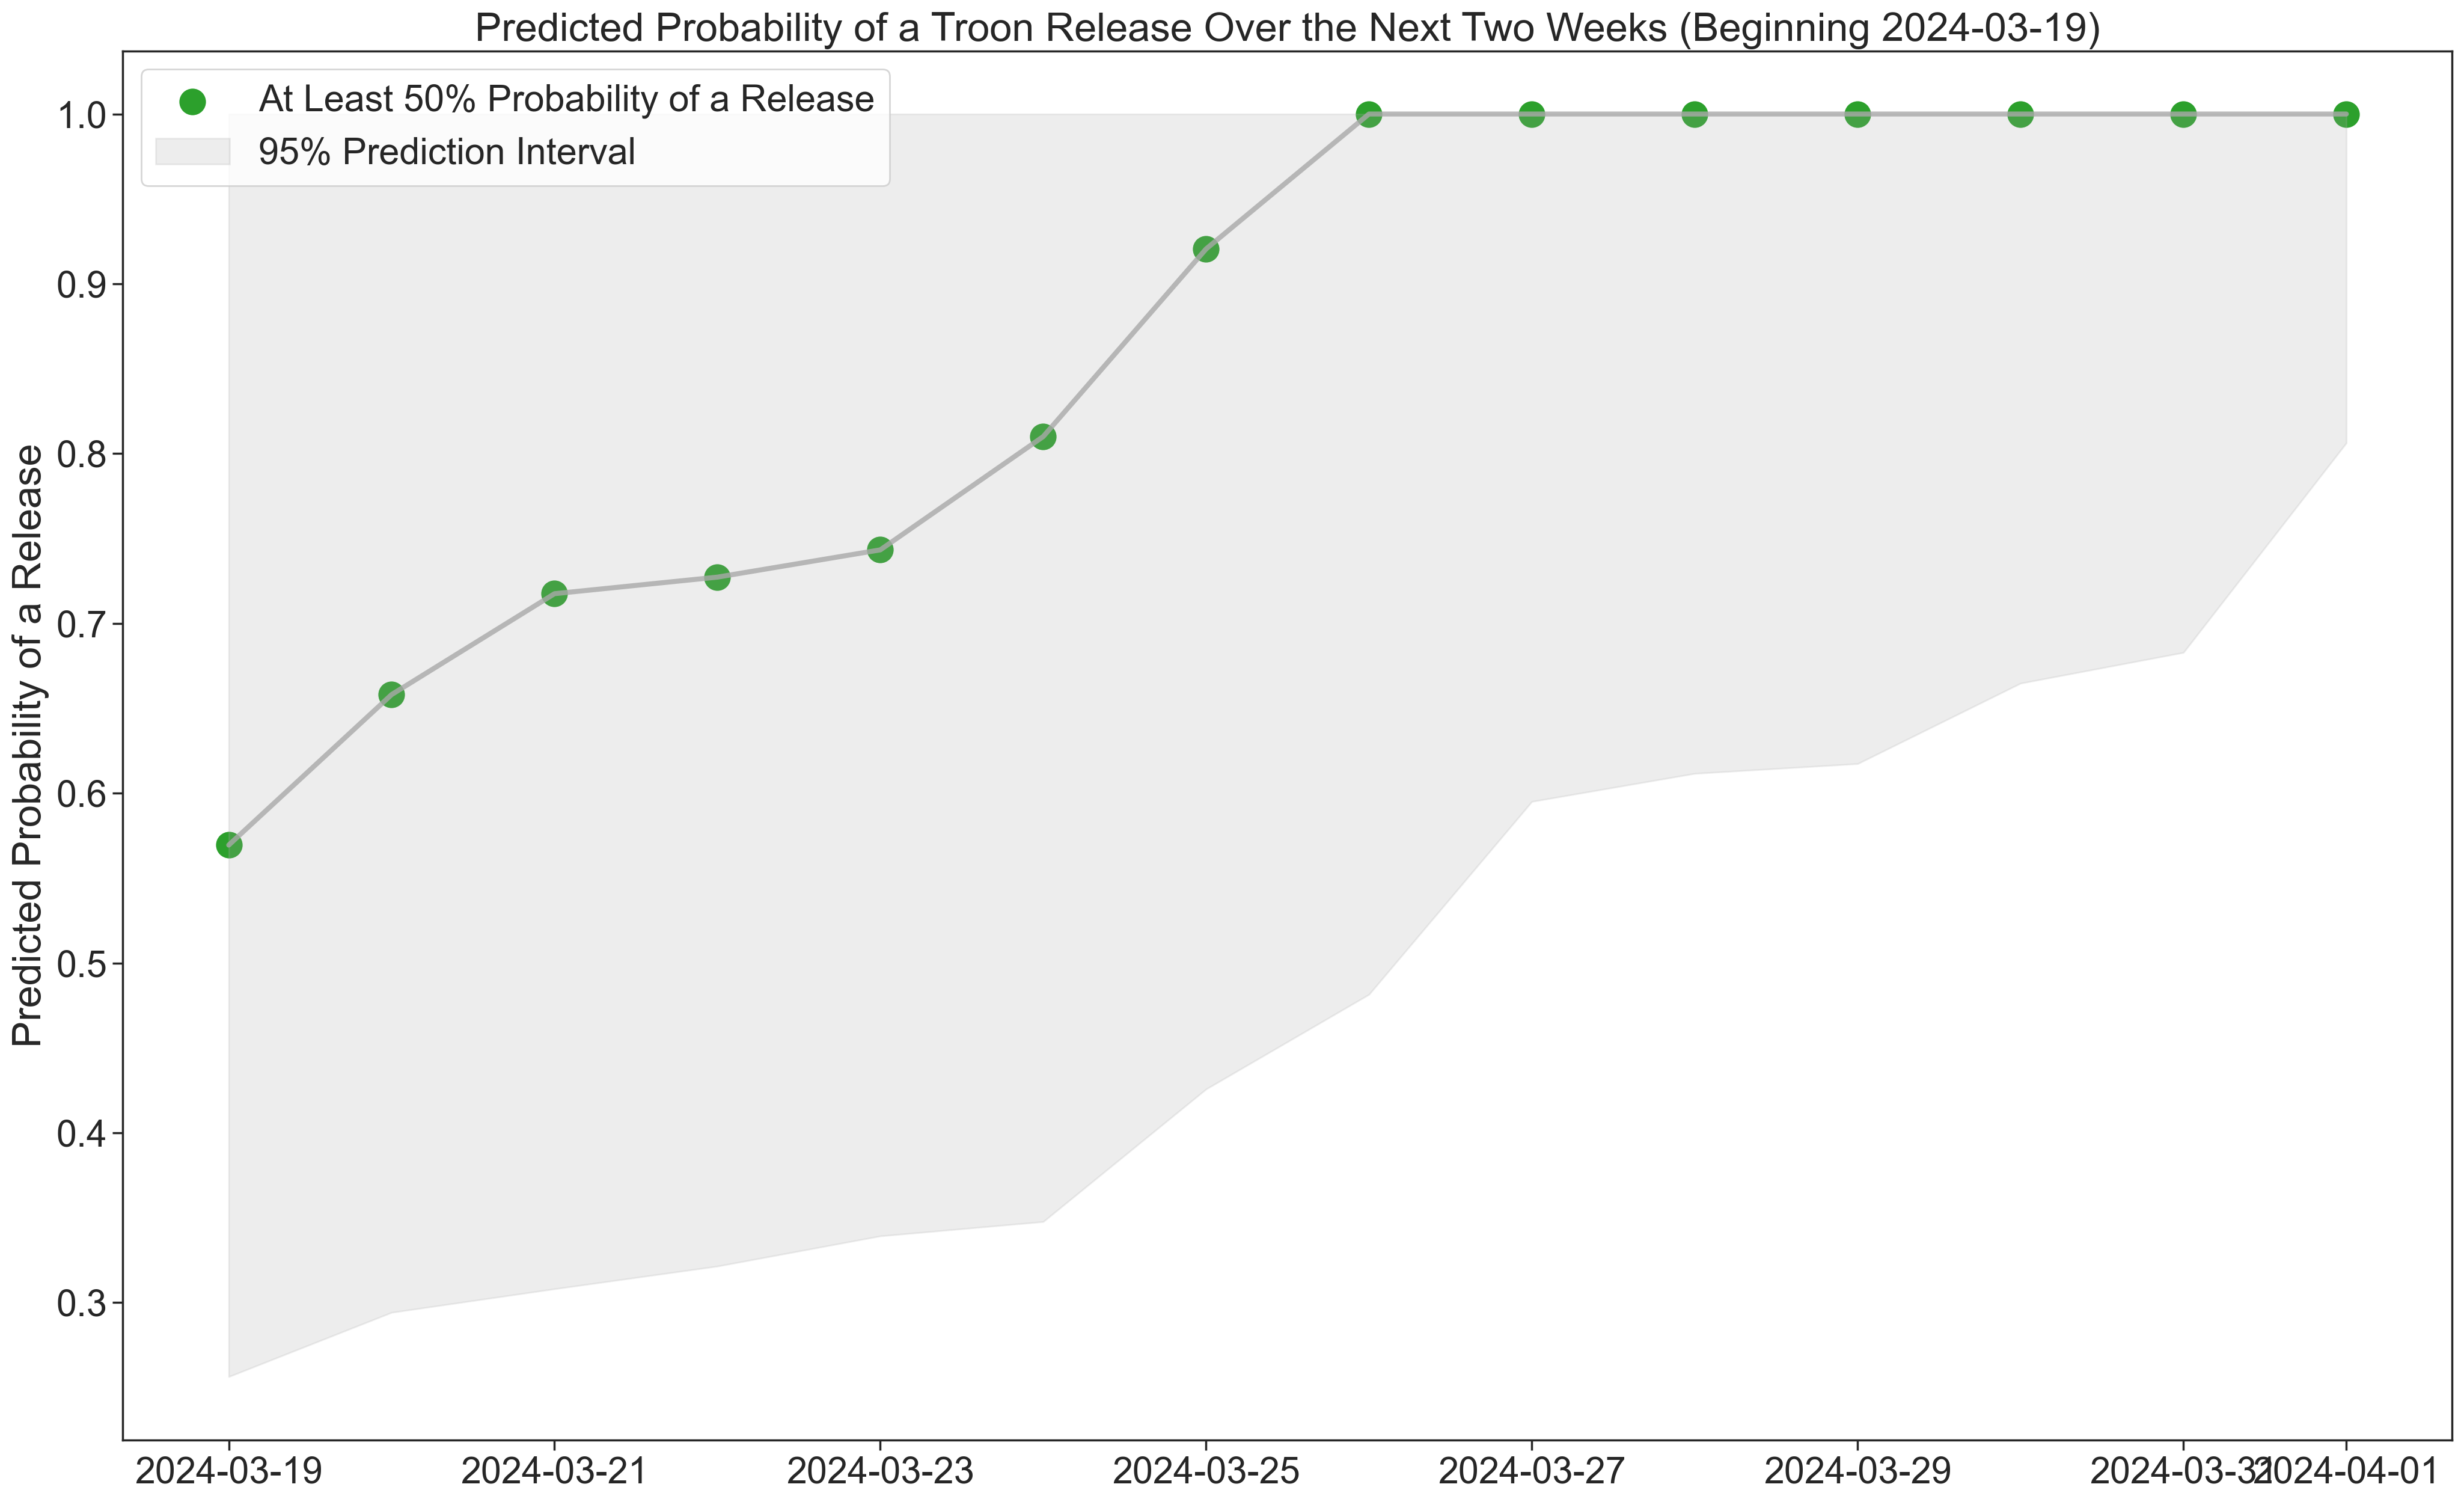

In [19]:
ax = sns.lineplot(data=next_month_hat[:14], x="ds", y="yhat", linewidth=3, color="darkgrey", alpha=0.8)
sns.scatterplot(data=next_month_hat[:14][next_month_hat["yhat"] >= 0.50], x="ds", y="yhat",
                s=300, ax=ax, color="tab:green", label="At Least 50% Probability of a Release")

ax.fill_between(x=next_month_hat[:14]["ds"],
                y1=next_month_hat[:14]["yhat_lower"],
                y2=next_month_hat[:14]["yhat_upper"],
                label="95% Prediction Interval",
                alpha=0.2,
                color="darkgrey")

ax.set_xlabel(None)
ax.set_ylabel("Predicted Probability of a Release")
ax.set_title("Predicted Probability of a Troon Release Over the Next Two Weeks (Beginning {})".format(
    next_month_hat["ds"].iloc[0].date()))
ax.legend()
plt.show()